# Bayesian Linear Regression

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating project at `d:\OneDrive - TU Eindhoven\phd\Projects\Packages\RxInfer.jl\examples`


In [2]:
using RxInfer, Random, Plots, StableRNGs, BenchmarkTools, LinearAlgebra, StatsPlots, LaTeXStrings

John recently purchased a new car and is interested in its fuel consumption rate. He believes that this rate has a linear relationship with speed, and as such, he wants to conduct tests by driving his car on different types of roads, recording both the fuel usage and speed. In order to determine the fuel consumption rate, John employs Bayesian linear regression.

## Univariate regression with known noise

First, he drives the car on a urban road. John enjoys driving on the well-built, wide, and flat urban roads. Urban roads also offer the advantage of precise fuel consumption measurement with minimal noise. Therefore John models the fuel consumption $y_n\in\mathbb{R}$ as a normal distribution:

$$\begin{aligned}
p(y_n \mid a, b) = \mathcal{N}(y_n \mid a x_n + b , 1)
\end{aligned}$$

The recorded speed is denoted as $x_n \in \mathbb{R}$ and the recorded fuel consumption as $y_n \in \mathbb{R}$. Prior beliefs on $a$ and $b$ are informed by the vehicle manual.

$$\begin{aligned}
    p(a) &= \mathcal{N}(a \mid m_a, v_a) \\
    p(b) &= \mathcal{N}(b \mid m_b, v_b) 
\end{aligned}$$

Together they form the probabilistic model
$$p(y, a, b) = p(a)p(b) \prod_{N=1}^N p(y_n \mid a, b),$$
where the goal is to infer the posterior distributions $p(a \mid y)$ and $p(b\mid y)$.

He records the speed and fuel consumption for the urban road which is the `xdata` and `ydata`.

In [3]:
function generate_data(a, b, v, nr_samples; rng=StableRNG(1234))
    x = float.(collect(1:nr_samples))
    y = a*x .+ b .+ randn(rng, nr_samples).*sqrt(v)
    return x, y
end;

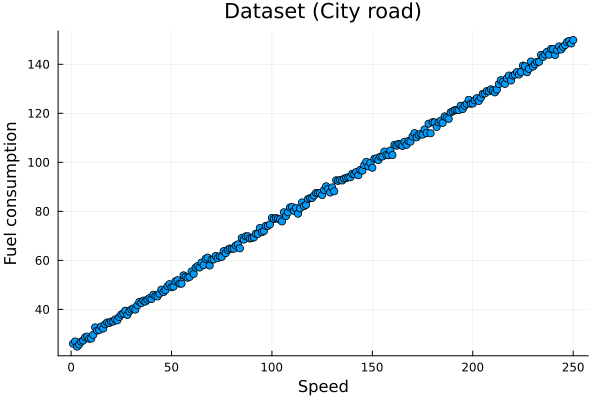

In [4]:
x_data, y_data = generate_data(0.5, 25.0, 1.0, 250)

scatter(x_data, y_data, title = "Dataset (City road)", legend=false)
xlabel!("Speed")
ylabel!("Fuel consumption")

In order to estimate the two parameters with the recorded data, he uses a `RxInfer.jl` to create the above described model.

In [5]:
@model function linear_regression(nr_samples)
    a ~ NormalMeanVariance(0.0, 1.0)
    b ~ NormalMeanVariance(0.0, 100.0)
    
    x = datavar(Float64, nr_samples)
    y = datavar(Float64, nr_samples)
    
    for n in 1:nr_samples
        y[n] ~ NormalMeanVariance(a * x[n] + b, 1.0)
    end
end

He is delighted that he can utilize the inference function from this package, saving him the effort of starting from scratch and enabling him to obtain the desired results for this road. He does note that there is a loop in his model, namely all $a$ and $b$ variables are connected over all observations, therefore he needs to initialize one of the messages and run multiple iterations for the loopy belief propagation algorithm.

In [6]:
results = inference(
    model        = linear_regression(length(x_data)), 
    data         = (y = y_data, x = x_data), 
    initmessages = (b = NormalMeanVariance(0.0, 100.0), ), 
    returnvars   = (a = KeepLast(), b = KeepLast()),
    iterations   = 20
)

Inference results:
  Posteriors       | available for (a, b)


He knows the theoretical coefficients and noise for this car from the manual. He is going to compare the experimental solution with theoretical results.

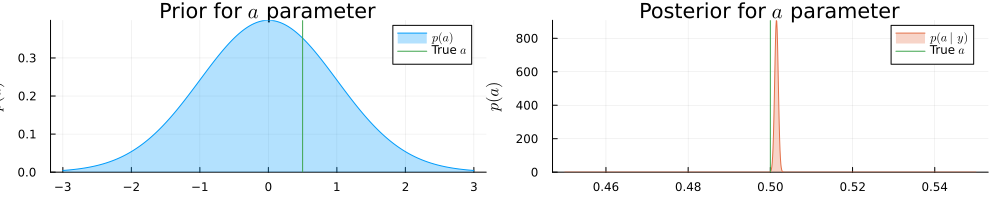

In [7]:
pra = plot(range(-3, 3, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 1.0), x), title=L"Prior for $a$ parameter", fillalpha=0.3, fillrange = 0, label=L"$p(a)$", c=1,)
pra = vline!(pra, [ 0.5 ], label=L"True $a$", c = 3)
psa = plot(range(0.45, 0.55, length = 1000), (x) -> pdf(results.posteriors[:a], x), title=L"Posterior for $a$ parameter", fillalpha=0.3, fillrange = 0, label=L"$p(a\mid y)$", c=2,)
psa = vline!(psa, [ 0.5 ], label=L"True $a$", c = 3)

plot(pra, psa, size = (1000, 200), xlabel=L"$a$", ylabel=L"$p(a)$", ylims=[0,Inf])

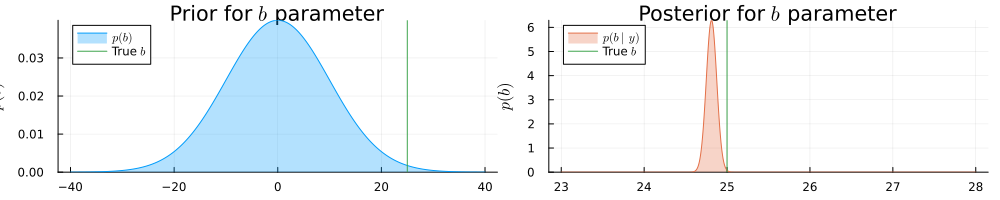

In [8]:
prb = plot(range(-40, 40, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 100.0), x), title=L"Prior for $b$ parameter", fillalpha=0.3, fillrange = 0, label=L"p(b)", c=1, legend = :topleft)
prb = vline!(prb, [ 25 ], label=L"True $b$", c = 3)
psb = plot(range(23, 28, length = 1000), (x) -> pdf(results.posteriors[:b], x), title=L"Posterior for $b$ parameter", fillalpha=0.3, fillrange = 0, label=L"p(b\mid y)", c=2, legend = :topleft)
psb = vline!(psb, [ 25 ], label=L"True $b$", c = 3)

plot(prb, psb, size = (1000, 200), xlabel=L"$b$", ylabel=L"$p(b)$", ylims=[0, Inf])

In [9]:
a = results.posteriors[:a]
b = results.posteriors[:b]

println("Real a: ", 0.5, " | Estimated a: ", mean_var(a), " | Error: ", abs(mean(a) - 0.5))
println("Real b: ", 25.0, " | Estimated b: ", mean_var(b), " | Error: ", abs(mean(b) - 25.0))

Real a: 0.5 | Estimated a: 

(0.501490188462706, 1.9162284531300301e-7) | Error: 0.001490188462705988
Real b: 25.0 | Estimated b: (24.81264210195605, 0.0040159675312827) | Error: 0.18735789804394898


## Univariate regression with unknown noise

Afterwards, he plans to test the car on a mountain road. However, mountain roads are typically narrow and filled with small stones, which makes it more difficult to establish a clear relationship between fuel consumption and speed, leading to an unknown level of noise in the regression model. Therefore, he design a model with unknown Inverse-Gamma distribution on the variance.
$$\begin{aligned}
p(y_n \mid a, b, s) &= \mathcal{N}(y_n \mid ax_n + b, s)\\
p(s) &= \mathcal{IG}(s\mid\alpha, \theta)\\
p(a) &= \mathcal{N}(a \mid m_a, v_a) \\
p(b) &= \mathcal{N}(b \mid m_b, v_b) 
\end{aligned}$$

In [10]:
@model function linear_regression_unknown_noise(nr_samples)
    a ~ NormalMeanVariance(0.0, 1.0)
    b ~ NormalMeanVariance(0.0, 100.0)
    s ~ InverseGamma(1.0, 1.0)
    
    x = datavar(Float64, nr_samples)
    y = datavar(Float64, nr_samples)
    
    for n in 1:nr_samples
        y[n] ~ NormalMeanVariance(a * x[n] + b, s)
    end
end

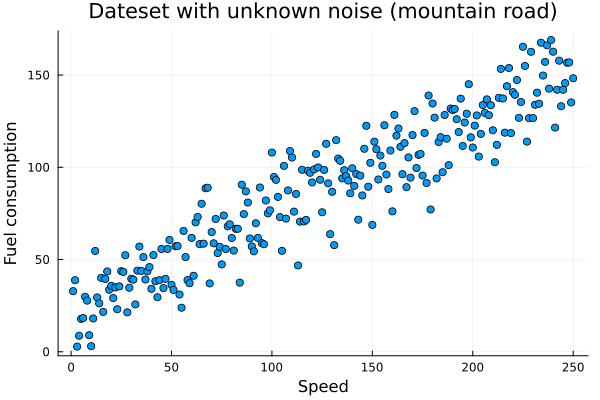

In [11]:
x_data_un, y_data_un = generate_data(0.5, 25.0, 200.0, 250)

scatter(x_data_un, y_data_un, title = "Dateset with unknown noise (mountain road)", legend=false)
xlabel!("Speed")
ylabel!("Fuel consumption")

To solve this problem in closed-from we need to resort to a variational approximation. In order to do so, he needs to set `constraints = MeanField()` as well as provide initial marginals with the `initmarginals` argument. He are also going to evaluate the convergency performance of the algorithm with the `free_energy = true` option:

In [12]:
results_unknown_noise = inference(
    model           = linear_regression_unknown_noise(length(x_data_un)), 
    data            = (y = y_data_un, x = x_data_un), 
    initmessages    = (b = NormalMeanVariance(0.0, 100.0), ), 
    returnvars      = (a = KeepLast(), b = KeepLast(), s = KeepLast()), 
    iterations      = 20,
    constraints     = MeanField(),
    initmarginals   = (s = vague(InverseGamma), ),
    free_energy     = true
)

Inference results:
  Posteriors       | available for (a, b, s)
  Free Energy:     | Real[1656.54, 1154.6, 1083.56, 1065.05, 1052.64, 1044.92, 1040.35, 1037.69, 1036.16, 1035.28, 1034.78, 1034.48, 1034.31, 1034.22, 1034.16, 1034.12, 1034.1, 1034.08, 1034.08, 1034.07]


Based on the Bethe free energy below, John knows that his algorithm has converged after 20 iterations:

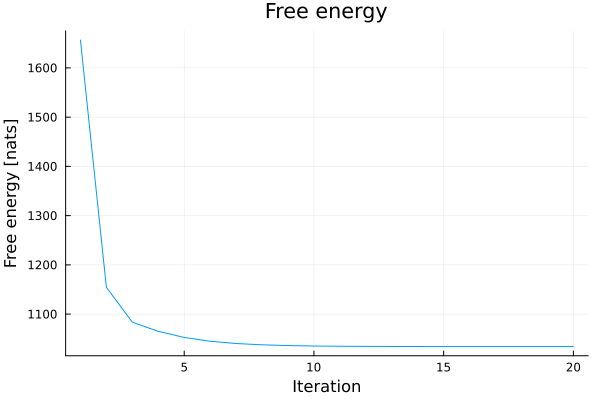

In [13]:
plot(1:20, results_unknown_noise.free_energy, title="Free energy", xlabel="Iteration", ylabel="Free energy [nats]", legend=false)

Below he visualizes the obtained posterior distributions for parameters:

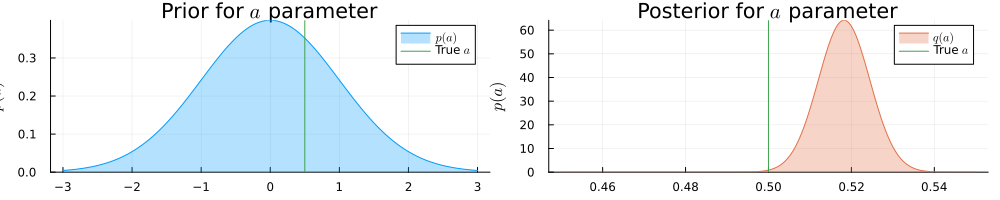

In [14]:
pra = plot(range(-3, 3, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 1.0), x), title=L"Prior for $a$ parameter", fillalpha=0.3, fillrange = 0, label=L"$p(a)$", c=1,)
pra = vline!(pra, [ 0.5 ], label=L"True $a$", c = 3)
psa = plot(range(0.45, 0.55, length = 1000), (x) -> pdf(results_unknown_noise.posteriors[:a], x), title=L"Posterior for $a$ parameter", fillalpha=0.3, fillrange = 0, label=L"$q(a)$", c=2,)
psa = vline!(psa, [ 0.5 ], label=L"True $a$", c = 3)

plot(pra, psa, size = (1000, 200), xlabel=L"$a$", ylabel=L"$p(a)$", ylims=[0, Inf])

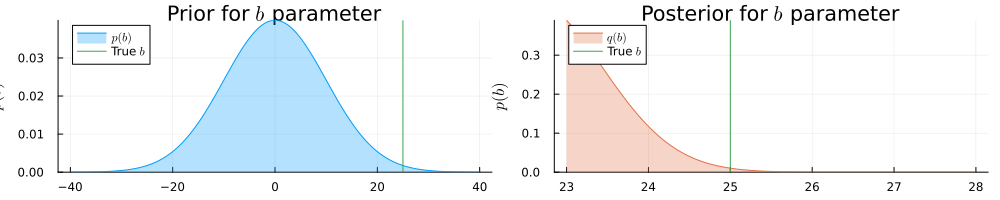

In [15]:
prb = plot(range(-40, 40, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 100.0), x), title=L"Prior for $b$ parameter", fillalpha=0.3, fillrange = 0, label=L"$p(b)$", c=1, legend = :topleft)
prb = vline!(prb, [ 25.0 ], label=L"True $b$", c = 3)
psb = plot(range(23, 28, length = 1000), (x) -> pdf(results_unknown_noise.posteriors[:b], x), title=L"Posterior for $b$ parameter", fillalpha=0.3, fillrange = 0, label=L"$q(b)$", c=2, legend = :topleft)
psb = vline!(psb, [ 25.0 ], label=L"True $b$", c = 3)

plot(prb, psb, size = (1000, 200), xlabel=L"$b$", ylabel=L"$p(b)$", ylims=[0, Inf])

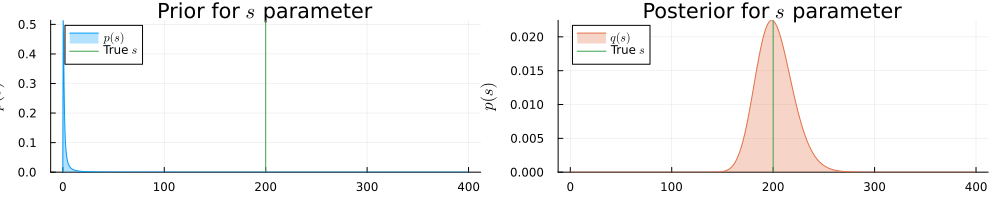

In [16]:
prb = plot(range(0.001, 400, length = 1000), (x) -> pdf(InverseGamma(1.0, 1.0), x), title=L"Prior for $s$ parameter", fillalpha=0.3, fillrange = 0, label=L"$p(s)$", c=1, legend = :topleft)
prb = vline!(prb, [ 200 ], label=L"True $s$", c = 3)
psb = plot(range(0.001, 400, length = 1000), (x) -> pdf(results_unknown_noise.posteriors[:s], x), title=L"Posterior for $s$ parameter", fillalpha=0.3, fillrange = 0, label=L"$q(s)$", c=2, legend = :topleft)
psb = vline!(psb, [ 200 ], label=L"True $s$", c = 3)

plot(prb, psb, size = (1000, 200), xlabel=L"$s$", ylabel=L"$p(s)$", ylims=[0, Inf])

He sees that in the presence of more noise the inference result is more uncertain about the actual values for $a$ and $b$ parameters.

John samples $a$ and $b$ and plot many possible regression lines on the same plot:

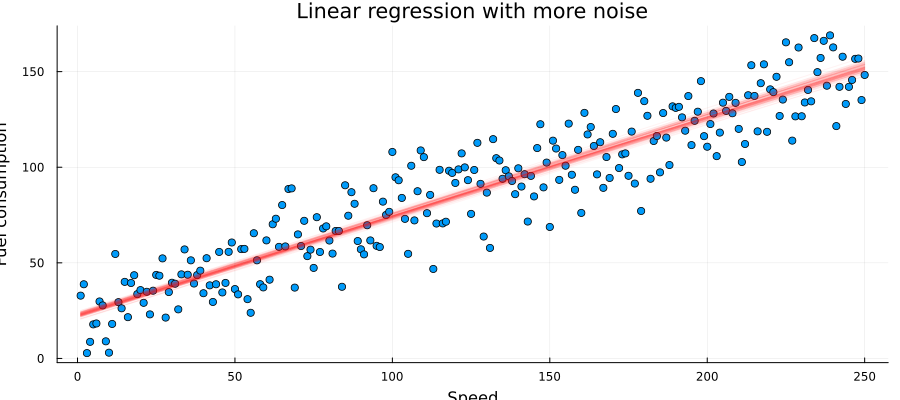

In [17]:
as = rand(results_unknown_noise.posteriors[:a], 100)
bs = rand(results_unknown_noise.posteriors[:b], 100)
p = scatter(x_data_un, y_data_un, title = "Linear regression with more noise", legend=false)
xlabel!("Speed")
ylabel!("Fuel consumption")
for (a, b) in zip(as, bs)
    global p = plot!(p, x_data_un, a .* x_data_un .+ b, alpha = 0.05, color = :red)
end

plot(p, size = (900, 400))

From this plot John can see that many lines do fit the data well and there is no definite "best" answer to the regression coefficients. He realize that most of these lines, however, resemble a similar angle and shift.

## Multivariate linear regression

In addition to fuel consumption, he is also interested in evaluating the car's power performance, braking performance, handling stability, smoothness, and other factors. To investigate the car's performance, he includes additional measurements. Essentially, this approach involves performing multiple linear regression tasks simultaneously, using multiple data vectors for x and y with different levels of noise. As in the previous example, he assumes the level of noise to be unknown.

In [18]:
@model function linear_regression_multivariate(dim, nr_samples)
    a ~ MvNormalMeanCovariance(zeros(dim), 100 * diageye(dim))
    b ~ MvNormalMeanCovariance(ones(dim), 100 * diageye(dim))
    W ~ InverseWishart(dim + 2, 100 * diageye(dim))

    # Here is a small trick to make the example work
    # We treat the `x` vector as a Diagonal matrix such that we can easily multiply it with `a`
    x = datavar(Diagonal{Float64, Vector{Float64}}, nr_samples)
    y = datavar(Vector{Float64}, nr_samples)
    z = randomvar(nr_samples)

    z .~ x .* a .+ b
    y .~ MvNormalMeanCovariance(z, W)

end

After received all the measurement records, he plots the measurements and performance index:

In [19]:
dim_mv = 6
nr_samples_mv = 50
rng_mv = StableRNG(42)
a_mv = randn(rng_mv, dim_mv)
b_mv = 10 * randn(rng_mv, dim_mv)
v_mv = 100 * rand(rng_mv, dim_mv)

x_data_mv, y_data_mv = collect(zip(generate_data.(a_mv, b_mv, v_mv, nr_samples_mv)...));

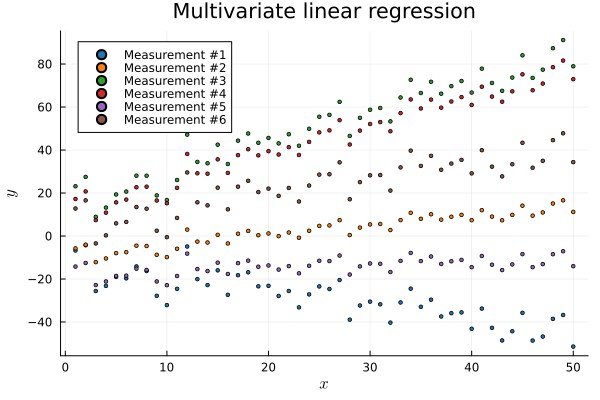

In [20]:
p = plot(title = "Multivariate linear regression", legend = :topleft)

plt = palette(:tab10)

data_set_label = [""]

for k in 1:dim_mv
    global p = scatter!(p, x_data_mv[k], y_data_mv[k], label = "Measurement #$k", ms = 2, color = plt[k])
end
xlabel!(L"$x$")
ylabel!(L"$y$")
p

Before this data can be used to perform inference, John needs to change its format slightly.

In [21]:
x_data_mv_processed = map(i -> Diagonal([getindex.(x_data_mv, i)...]), 1:nr_samples_mv)
y_data_mv_processed = map(i -> [getindex.(y_data_mv, i)...], 1:nr_samples_mv);

In [22]:
results_mv = inference(
    model           = linear_regression_multivariate(dim_mv, nr_samples_mv),
    data            = (y = y_data_mv_processed, x = x_data_mv_processed),
    initmarginals   = (W = InverseWishart(dim_mv + 2, 10 * diageye(dim_mv)), ),
    initmessages    = (b = MvNormalMeanCovariance(ones(dim_mv), 10 * diageye(dim_mv)), ),
    returnvars      = (a = KeepLast(), b = KeepLast(), W = KeepLast()),
    free_energy     = true,
    iterations      = 50,
    constraints     = MeanField()
)

Inference results:
  Posteriors       | available for (a, b, W)
  Free Energy:     | Real[864.485, 789.026, 769.094, 750.865, 737.67, 724.722, 712.341, 700.865, 690.782, 682.505  …  664.434, 664.434, 664.434, 664.434, 664.434, 664.434, 664.434, 664.434, 664.434, 664.434]


Again, the algorithm nicely converged, because the Bethe free energy reached a plateau. John also draws the results for the linear regression parameters and sees that the lines very nicely follow the provided data.

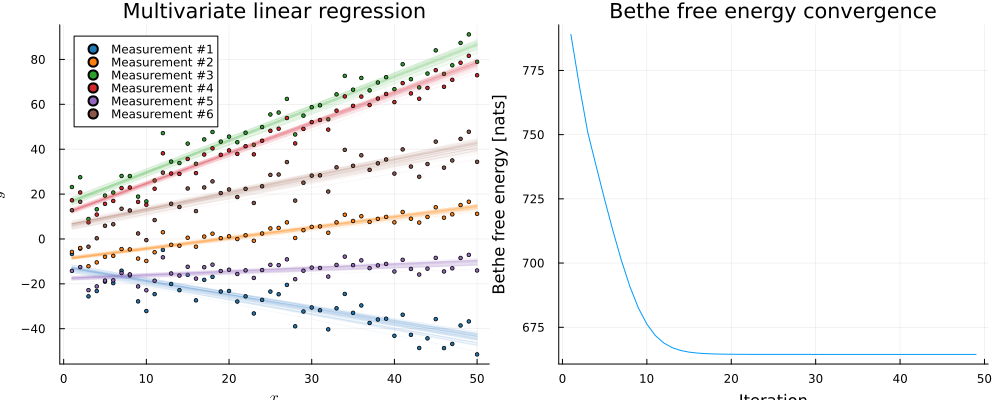

In [23]:
p = plot(title = "Multivariate linear regression", legend = :topleft, xlabel=L"$x$", ylabel=L"$y$")

# how many lines to plot
r = 50

i_a = collect.(eachcol(rand(results_mv.posteriors[:a], r)))
i_b = collect.(eachcol(rand(results_mv.posteriors[:b], r)))

plt = palette(:tab10)

for k in 1:dim_mv
    x_mv_k = x_data_mv[k]
    y_mv_k = y_data_mv[k]

    for i in 1:r
        global p = plot!(p, x_mv_k, x_mv_k .* i_a[i][k] .+ i_b[i][k], label = nothing, alpha = 0.05, color = plt[k])
    end

    global p = scatter!(p, x_mv_k, y_mv_k, label = "Measurement #$k", ms = 2, color = plt[k])
end

# truncate the init step
f = plot(results_mv.free_energy[2:end], title ="Bethe free energy convergence", label = nothing, xlabel = "Iteration", ylabel = "Bethe free energy [nats]") 

plot(p, f, size = (1000, 400))

He needs more iterations to converge in comparison to the very first example, but that is expected since the problem became multivariate and, hence, more difficult.

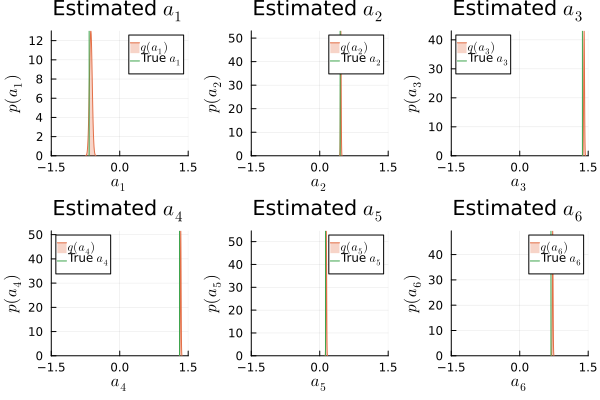

In [24]:
i_a_mv = results_mv.posteriors[:a]

ps_a = []

for k in 1:dim_mv
    
    local _p = plot(title = L"Estimated $a_{%$k}$", xlabel=L"$a_{%$k}$", ylabel=L"$p(a_{%$k})$", xlims = (-1.5,1.5), xticks=[-1.5, 0, 1.5], ylims=[0, Inf])

    local m_a_mv_k = mean(i_a_mv)[k]
    local v_a_mv_k = std(i_a_mv)[k, k]
    
    _p = plot!(_p, Normal(m_a_mv_k, v_a_mv_k), fillalpha=0.3, fillrange = 0, label=L"$q(a_{%$k})$", c=2,)
    _p = vline!(_p, [ a_mv[k] ], label=L"True $a_{%$k}$", c = 3)
           
    push!(ps_a, _p)
end

plot(ps_a...)

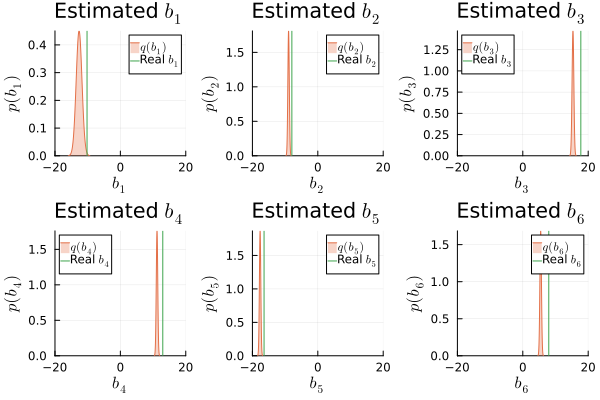

In [25]:
i_b_mv = results_mv.posteriors[:b]

ps_b = []

for k in 1:dim_mv
    
    local _p = plot(title = L"Estimated $b_{%$k}$", xlabel=L"$b_{%$k}$", ylabel=L"$p(b_{%$k})$", xlims = (-20,20), xticks=[-20, 0, 20], ylims =[0, Inf])
    local m_b_mv_k = mean(i_b_mv)[k]
    local v_b_mv_k = std(i_b_mv)[k, k]

    _p = plot!(_p, Normal(m_b_mv_k, v_b_mv_k), fillalpha=0.3, fillrange = 0, label=L"$q(b_{%$k})$", c=2,)
    _p = vline!(_p, [ b_mv[k] ], label=L"Real $b_{%$k}$", c = 3)
           
    push!(ps_b, _p)
end

plot(ps_b...)

He also checks the noise estimation procedure and sees that the noise variance are currently a bit underestimated. Note here that he neglects the covariance terms between the individual elements, which might result in this kind of behaviour.

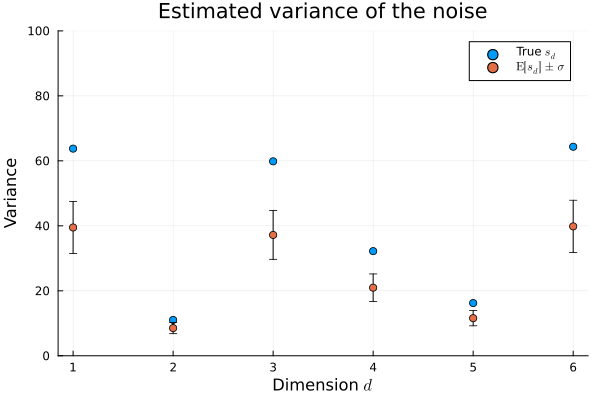

In [26]:
scatter(1:dim_mv, v_mv, ylims=(0, 100), label=L"True $s_d$")
scatter!(1:dim_mv, diag(mean(results_mv.posteriors[:W])); yerror=sqrt.(diag(var(results_mv.posteriors[:W]))), label=L"$\mathrm{E}[s_d] \pm \sigma$")
plot!(; xlabel=L"Dimension $d$", ylabel="Variance", title="Estimated variance of the noise")